# One-vs-all logistic regression model

**Problem description:**

Implement and train a one-vs-all multi-class classifier logistic regression model, trained to differentiate between between 20x20 images showing handwritten digits from 0 to 9.

**Note:**

Ideally we would like a split of separate training, test and cross-validation samples. In contrast here we only deal with the training set, as the emphasis is on:
- demonstrating logistic regression
- one-vs-all multi-class classification procedure

**Notation:**

- $\theta_{j}$: weights, $j=1,...,n$
- $x^{(i)}_{j}$: the $j$-th feature of the $i$-th sample, $i=1,..,m$, $j=1,...,n$
- $y^{(i)}$: $i$-th label, $i=1,..,m$


**Vectorized form:**

Design/data matrix/features:

\begin{equation}
    X
    =
    \begin{bmatrix}
    -- (x^{(1)})^{T} -- \\
    -- (x^{(2)})^{T} -- \\
    ... \\
    -- (x^{(m)})^{T} --
    \end{bmatrix}
\end{equation}

Parameters/weights:

\begin{equation}
    \theta
    =
    \begin{bmatrix}
    \theta_{1} \\
    \theta_{2} \\
    ... \\
    \theta_{n}
    \end{bmatrix}
\end{equation}

Labels:

\begin{equation}
    y
    =
    \begin{bmatrix}
    y^{(1)} \\
    y^{(2)} \\
    ... \\
    y^{(m)}
    \end{bmatrix}
\end{equation}

**Dimensions:**
- $m$: number of samples
- $n$: number of weights

### Model:

Logistics function:

\begin{equation}
    h_{\theta}(x^{(i)})
    =
    \sigma(\theta^{T} x^{(i)})
    =
    \frac{1}{1 + e^{- \theta^{T} x^{(i)} }}
\end{equation}

where $\sigma(z)$ is the sigmoid function:

\begin{equation}
    \sigma(z)
    =
    \frac{1}{1 + e^{-z}}
\end{equation}

We wish to achive:

\begin{equation}
h_{\theta}(x^{(i)}) \simeq y^{(i)}
\end{equation}

### Cost function

\begin{equation}
    J(\theta)
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        -y^{(i)} \log( h_{\theta}(x^{(i)}) - (1-y^{(i)}) \log(1-h_{\theta}(x^{(i)})
    \right]
    +
    \frac{\lambda}{2m}
    \sum_{j=1}^{n}
    \theta^{2}_{j}
\end{equation}

### Gradient

The $j=0$ component:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
\end{equation}

$j \neq 0$ components:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
    +
    \frac{\lambda}{m} \theta_{j}
\end{equation}

Vectorized form:

\begin{equation}
    \underline{\theta}'
    =
    \begin{bmatrix}
        0 \\
        \theta_{1} \\
        \theta_{2} \\
        ... \\
        \theta_{n}
    \end{bmatrix}
\end{equation}

\begin{equation}
    \nabla_{\theta} J
    =
    \frac{1}{m}
    \underline{\underline{X}}^{T}
    (
        \underline{h_{\theta}}(x)
        -
        \underline{y}
    )
    +
    \frac{\lambda}{m}
    \underline{\theta'}
\end{equation}

In [1]:
import pandas as pd
import numpy as np
import scipy.io
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

Load in .mat datafile containing the digits

In [2]:
data = scipy.io.loadmat('ex3data1.mat')

In [3]:
features = data['X']
labels = data['y'][:,0]
X = np.insert(data['X'], 0, 1, axis=1)
y = data['y'][:,0]

Replace all 10s (denoting a 0 digit) with 0s in order to more seamlessly conform to the convention of indexing in python (0,...,K-1)

In [4]:
y[y==10] = 0

### Examples

In [5]:
def show_digit(flat_pixels):
    img = flat_pixels.reshape([20,20])
    img_rot = np.rot90(img)
    plt.imshow(img_rot, cmap='gray_r', origin='lower');

[2]


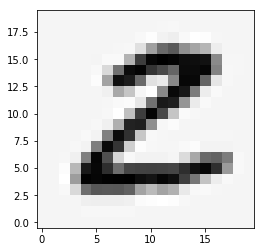

In [6]:
pick = 1012
show_digit(data['X'][pick]);
print(data['y'][pick])

Pick a couple of images at random

In [7]:
picks = np.random.choice(data['X'].shape[0], 10)

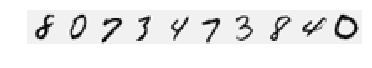

In [8]:
f,a = plt.subplots()
a.imshow(data['X'][picks].reshape(-1,20).T, cmap='gray_r')
a.axis('off');

### Function definitions

In [9]:
def sigmoid(z):
    s = 1.0 / ( 1.0 + np.exp(-z) )
    return s

Hypothesis:

\begin{equation}
    h_{\theta}(x^{(i)})
    =
    \sigma(\theta^{T} x^{(i)})
    =
    \frac{1}{1 + e^{- \theta^{T} x^{(i)} }}
\end{equation}

In [10]:
def hypothesis(theta,X):
    z = X.dot(theta)
    h = sigmoid(z)
    return h

Cost function:

\begin{equation}
    J(\theta)
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        -y^{(i)} \log( h_{\theta}(x^{(i)}) - (1-y^{(i)}) \log(1-h_{\theta}(x^{(i)})
    \right]
    +
    \frac{\lambda}{2m}
    \sum_{j=1}^{n}
    \theta^{2}_{j}
\end{equation}

In [11]:
def cost_function(theta, X, y, lam=0):
    """ theta: nx1
        X: mxn
        theta: nx1
        lam: 1
    """
    m = len(X)
    h = hypothesis(theta, X)
    cost_vector = -y * np.log(h) - (1.0-y)*np.log(1.0 - h)
    regularization_term = np.sum(theta**2) * lam/(2.0*m)
    cost = np.sum(cost_vector)/m + regularization_term
    return cost

The $j=0$ component:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
\end{equation}

$j \neq 0$ components:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
    +
    \frac{\lambda}{m} \theta_{j}
\end{equation}

In [12]:
def gradient(theta, X, y, lam=0):
    """- X: mxn
       - y: mx1
       - theta: nx1
       - lam: 1"""
    m = len(X)
    h = hypothesis(theta,X)
    thetap = theta
    thetap[0] = 0
    gradient = (X.transpose().dot(h-y) + lam*thetap)/m
    return gradient

In [13]:
def accuracy(yreal, ypred):
    return np.mean(yreal==ypred)

## Single class logistic regression

Train on a single, specific digit

In [14]:
digit = 2

Create target vector

In [15]:
y_single = (y == digit).astype(int)

In [16]:
index = np.where(y == 1)[0][100]

In [17]:
index

600

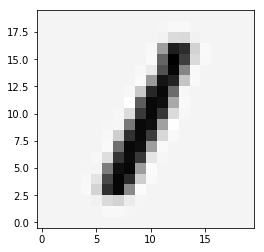

In [18]:
show_digit(data['X'][index]);

In [19]:
theta0 = np.random.uniform(high=0.1, size=401)

In [20]:
cost_function(theta0, X, y_single)

2.4461421556308922

In [21]:
gradient(theta0,X,y_single,lam=0.0)

array([  8.16935448e-01,   0.00000000e+00,   0.00000000e+00,
         1.29741079e-07,  -1.67437908e-06,  -2.59847851e-06,
         1.15809090e-04,   1.35362088e-04,   6.75326758e-05,
         1.39840208e-05,   4.05892201e-05,   1.35114551e-05,
        -1.01677849e-05,  -2.21261713e-05,  -3.75508323e-05,
        -5.26064013e-05,  -3.96729376e-05,  -1.36540933e-05,
        -8.88905083e-08,   1.41740283e-07,   0.00000000e+00,
         4.71778793e-08,  -3.85012632e-07,  -1.58411791e-06,
        -4.35916835e-06,  -2.69926411e-05,   1.14460610e-04,
         5.50071109e-04,   8.18325789e-04,   6.45310170e-04,
         2.35387325e-04,  -8.97745503e-05,  -1.60518744e-04,
        -9.75275636e-05,  -4.57962032e-05,   8.10228493e-05,
         9.05502012e-05,   8.32946157e-07,  -4.58740880e-05,
        -7.71336100e-06,  -1.55959656e-06,  -4.04287517e-07,
         3.61816387e-06,  -1.57471350e-05,   1.76985313e-04,
         8.57321925e-04,   2.34402950e-03,   4.10307807e-03,
         4.94949170e-03,

In [22]:
h = hypothesis(theta0, X)

In [23]:
h

array([ 0.94459903,  0.97078742,  0.97655477, ...,  0.86304725,
        0.97486625,  0.96253626])

### Optimization

Minimize a function using a nonlinear conjugate gradient algorithm, implemented in `scipy.optimize.fmin_cg`

Usage:
~~~~
scipy.optimize.fmin_cg(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None)
~~~~

Perform optimization with different choices for the regularization parameter $\lambda$ in the range of $[0,1]$

In [24]:
lambdas = np.linspace(0.0, 3.0, 6)

In [25]:
theta_opts, theta_iters = {}, {}
for lam in lambdas:
    theta_opt, theta_iter = optimize.fmin_cg(f=cost_function, fprime=gradient, x0=theta0, args=(X, y_single, lam), maxiter=50, retall=True)
    theta_opts[lam] = theta_opt
    theta_iters[lam] = theta_iter

         Current function value: 0.053438
         Iterations: 50
         Function evaluations: 143
         Gradient evaluations: 143
         Current function value: 0.065850
         Iterations: 50
         Function evaluations: 143
         Gradient evaluations: 143
         Current function value: 0.071697
         Iterations: 50
         Function evaluations: 138
         Gradient evaluations: 138
         Current function value: 0.076095
         Iterations: 50
         Function evaluations: 190
         Gradient evaluations: 189
         Current function value: 0.079678
         Iterations: 50
         Function evaluations: 190
         Gradient evaluations: 190
         Current function value: 0.083244
         Iterations: 27
         Function evaluations: 163
         Gradient evaluations: 151


### Evolution of cost function with the number of iterations

In [26]:
costs = {}
for lam, theta_iter in theta_iters.items():
    costs[lam] = [cost_function(theta, X, y_single, lam) for theta in theta_iter]

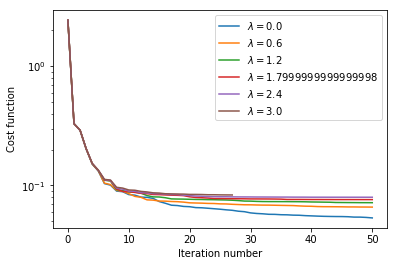

In [27]:
f,a = plt.subplots()
for lam, cost in costs.items():
    a.plot(cost, label="$\lambda = {}$".format(lam))
a.set_yscale('log')
a.set_xlabel('Iteration number')
a.set_ylabel('Cost function')
plt.legend()

The $l^{2}$ norm of the parameter vector $\theta$:

In [28]:
theta_l2 = [np.mean(theta_opt**2) for lam, theta_opt in theta_opts.items()]

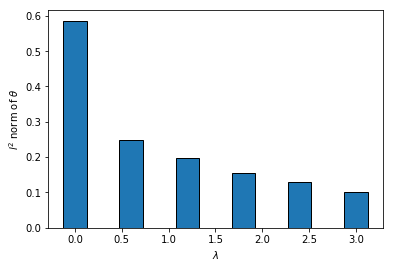

In [29]:
f,a = plt.subplots()
a.bar(lambdas, theta_l2, align='center', edgecolor='k', width=0.25)
a.set_xlabel('$\lambda$')
a.set_ylabel(r'$l^{2}$ norm of $\theta$')

### Accuracy

In [30]:
y_single

array([0, 0, 0, ..., 0, 0, 0])

Get the predicted $y$ values:

In [31]:
y_predicted = hypothesis(theta_opts[0],X)

In [32]:
y_predicted

array([  2.16449116e-04,   1.53286523e-05,   4.21071518e-04, ...,
         1.51760286e-03,   1.36434054e-09,   5.12030687e-06])

Accuracy on the training set (we'd also need the accuracy on the test set)

In [33]:
accuracy(y_single, y_predicted)

0.0

## Multi class classification with the one-vs-all method

**Notation**:

- $[k]$ class index $[k]=1,...,K$

The labels $y$ belong to one of the $K=10$ distinct classes (digits from 0 to 9) and the goal here is to train $K$ separate logistic regression units each specializing in a specific digit.

In [34]:
K = 10

In [35]:
lambdas = [1.0]

In [36]:
theta_opts, theta_iters, cost_iters = {}, {}, {}

In [37]:
for lam in lambdas:
    
    n = len(X[0])
    theta_opts[lam] = np.zeros((n,K))
    theta_iters[lam] = {}
    cost_iters[lam] = {}
    
    for k in range(K):
        digit = k
        y_target = (y == digit).astype(int)
        
        theta0 = np.random.uniform(high=0.1, size=401)
        theta_opt, theta_iter = optimize.fmin_cg(f=cost_function, fprime=gradient, x0=theta0, args=(X, y_target, lam), maxiter=50, retall=True)

        theta_opts[lam][:,k] = theta_opt
        theta_iters[lam][k] = theta_iter
        cost_iters[lam][k] = [cost_function(theta, X, y_target, lam) for theta in theta_iter]

         Current function value: 0.022525
         Iterations: 34
         Function evaluations: 200
         Gradient evaluations: 189
         Current function value: 0.027548
         Iterations: 50
         Function evaluations: 206
         Gradient evaluations: 206
         Current function value: 0.069630
         Iterations: 50
         Function evaluations: 154
         Gradient evaluations: 154
         Current function value: 0.074268
         Iterations: 50
         Function evaluations: 182
         Gradient evaluations: 182
         Current function value: 0.052595
         Iterations: 50
         Function evaluations: 136
         Gradient evaluations: 136
         Current function value: 0.077397
         Iterations: 50
         Function evaluations: 123
         Gradient evaluations: 123
         Current function value: 0.035874
         Iterations: 50
         Function evaluations: 165
         Gradient evaluations: 165
         Current function value: 0.047167
      

#### Convergence

In [38]:
lam = 1.0

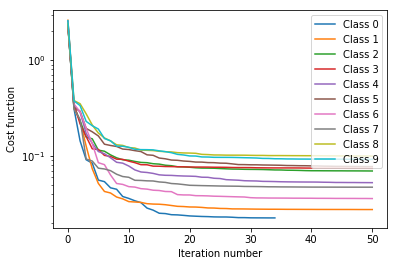

In [39]:
f,a = plt.subplots()
for k, cost_iter in cost_iters[lam].items():
    a.plot(cost_iter, label="Class {}".format(k))
a.set_yscale('log')
a.set_xlabel('Iteration number')
a.set_ylabel('Cost function')
plt.legend()

#### Result: prediction for the training set

In [40]:
def one_vs_all(theta_opts, X, y):
    h = hypothesis(theta_opts, X)
    kmax = np.argmax(h, axis=1)
    y_pred = kmax
    
    return y_pred

In [41]:
lam = 1.0

In [42]:
y_pred = one_vs_all(theta_opts[lam], X, y)

#### Accuracy of prediction

In [43]:
accuracy(labels, y_pred)

0.94199999999999995

### Other statistics

#### Confusion matrix

In [44]:
def plot_confusion_matrix(matrix, cmap='viridis', vmax=0.05, label_format="{:.3f}"):
    nx, ny = matrix.shape
    f,a = plt.subplots(figsize=(9,9), subplot_kw={'aspect':'equal'})
    a.set_ylabel('Truth')
    a.set_xlabel('Predicted')
    im = a.imshow(matrix, cmap=cmap, vmax=vmax)

    for x in range(nx):
        for y in range(ny):
            label = label_format.format(matrix[x][y])
            a.annotate(label, xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    cb = f.colorbar(im)
    a.set_xticks(range(K));
    a.set_yticks(range(K));

In [45]:
def construct_confusion_matrix(truths, preds):
    
    K = len(np.unique(truths))
    confusion = np.zeros((K,K))
    for truth, pred in zip(truths, preds):
        confusion[truth][pred] += 1
    return confusion

In [46]:
def normalize_confusion_matrix(confusion):
    normalized = (confusion.T / np.sum(confusion, axis=1)).T
    return normalized

In [47]:
confusion = construct_confusion_matrix(labels,y_pred)

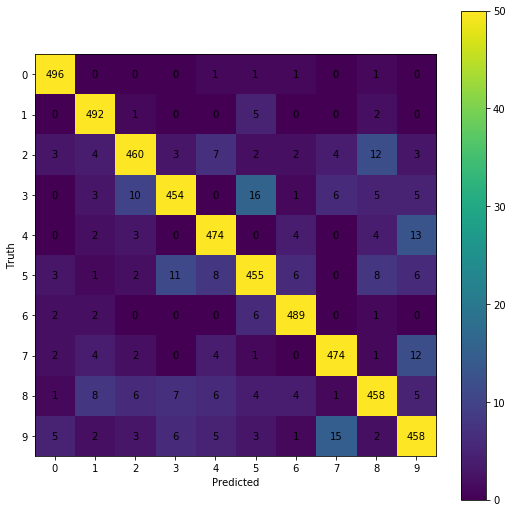

In [48]:
plot_confusion_matrix(confusion, vmax=50, label_format="{:.0f}")

**Normalized version**

In [49]:
confusion_normalized = normalize_confusion_matrix(confusion)

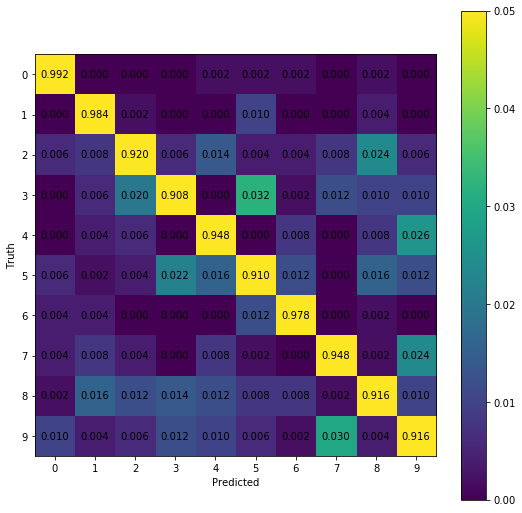

In [50]:
plot_confusion_matrix(confusion_normalized)

#### Most frequent missclassified digits

In [51]:
most_frequent_digits = np.argsort(-confusion_normalized, axis=1)

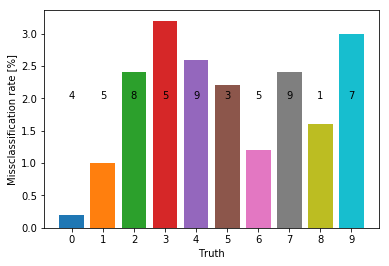

In [52]:
f,a = plt.subplots()
for i,row in enumerate(most_frequent_digits):
    second_most_frequent_digit = row[1]
    a.bar(i, confusion_normalized[i][second_most_frequent_digit]*100.0)
    a.annotate(second_most_frequent_digit, xy=(i,2), horizontalalignment='center')
a.set_xticks(range(10));
a.set_xlabel('Truth')
a.set_ylabel('Missclassification rate [%]');

## Multi class classification with the one-vs-all method in `scikit-learn`

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

~~~~
 class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)[source]
~~~~

In [53]:
from sklearn.linear_model import LogisticRegression

**Notes about `LogisticRegression`:**
- the class automatically infers the number of categories to be classified from the labels, so there is no need to specify the number of classes explicitly
- the bias terms are handled internally, therefore it is possible to directly feed the features to it, without prepending the design matrix with the bias column as done above

In [54]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')

In [55]:
clf.fit(data['X'],data['y'])

/home/edy/lib/build/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
y_pred = clf.predict(data['X'])

In [57]:
y_pred

array([0, 0, 0, ..., 9, 9, 7], dtype=uint8)

In [58]:
accuracy(labels,y_pred)

0.96499999999999997

In [59]:
confusion_sklearn = construct_confusion_matrix(labels, y_pred)

In [60]:
confusion_sklearn_normalized = normalize_confusion_matrix(confusion_sklearn)

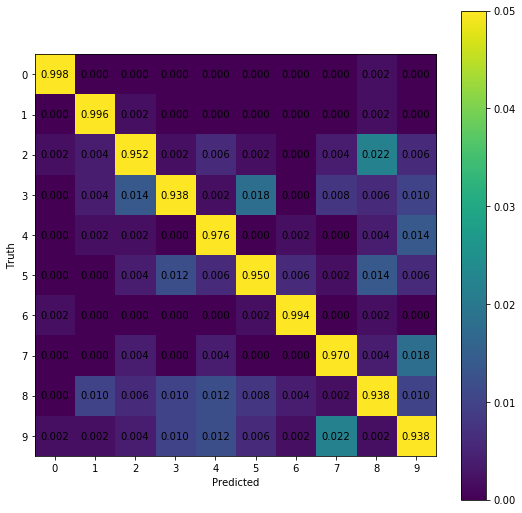

In [61]:
plot_confusion_matrix(confusion_sklearn_normalized)

----

----

----

## Test area